# Principal Component Analysis (PCA)

This notebook implements the custom principal component analysis (PCA) algorithm on the Wine dataset. Here, PCA is used to create principal components that accurately capture variance in the existing numerical data. The objective of this task is to validate the use of the custom PCA algorithm, and evaluate its performance on a fairly sizable feature set.

The following sections are included in this notebook:
1. **Library Imports**
- Importing the necessary modules, packages, and libraries
- Specifies dependencies and preferred versions
2. **Data Loading and Cleaning**
- Loads the Wine dataset with relevant features
- Drops outliers, duplicates, and missing data
3. **Data Visualization**
- Visualizes the correlation between features using a heatmap
4. **PCA Implementation**
- Implements the custom-built PCA algorithm
- Determines the optimal number of components through examining explained variance and eigenvalues
5. **Comparison with Existing Models**
- Runs the scikit-learn version of PCA
- Compares the results with the custom-built class to verify the latter

*For a more comprehensive overview of the PCA algorithm, code structure, and metrics used, see the associated [README](README.md).*

### Library Imports
This section imports the packages and modules required to run PCA. The following dependencies (with recommended versions) are required:
- Python 3.9.6
- Numpy 1.26.4
- Pandas 2.3.3
- Matplotlib 3.9.4
- Seaborn 0.13.2
- Sklearn 1.6.1

In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from rice_ml.preprocess import *
from rice_ml.unsupervised_learning.pca import *
import sklearn

### Data Loading & Cleaning
*Loading and preprocessing data*

The data used in this notebook comes from the Wine dataset. Although this dataset is typically used for either supervised regression or classification, it contains fairly sizable number of features that make it suitable for dimensionality reduction using PCA. Additionally, it allows for several data cleaning steps that showcase the `rice_ml` preprocessing modules. All thirteen numeric features are included, excluding the *target* feature, which is categorical in nature.

The data is first loaded as a Pandas DataFrame.

In [210]:
# Loading the dataset
wine_data = sklearn.datasets.load_wine(as_frame = True)
wine_data = wine_data.frame
display(wine_data)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


To ensure that the dataset does not contain missing data, we apply a series of preprocessing steps using functions from the `preprocessing` package, including dropping any rows with missing values, outliers, or that are identified to be duplicates of another. In addition, we drop the column with the *target* variable.

In [220]:
# Cleaning the data (removing missing data, outliers, or duplicate rows)
wine_data_missing = missing_data(wine_data, 'drop')
wine_data_outliers = outlier_identify(wine_data_missing, 'zscore', drop = True)
wine_data_cleaned = duplicate_identify(wine_data_missing[:, :-1], True)

### Data Visualization
*Correlation plotting*

Once the data has been appropriately cleaned, the relationships between variables can be visualized through correlation analysis. We identify the correlations between features using a heatmap of a calculated correlation matrix, applied to the cleaned DataFrame that includes all features. Doing so allows us to determine whether the data is sufficiently correlated for dimensionality reduction using PCA.

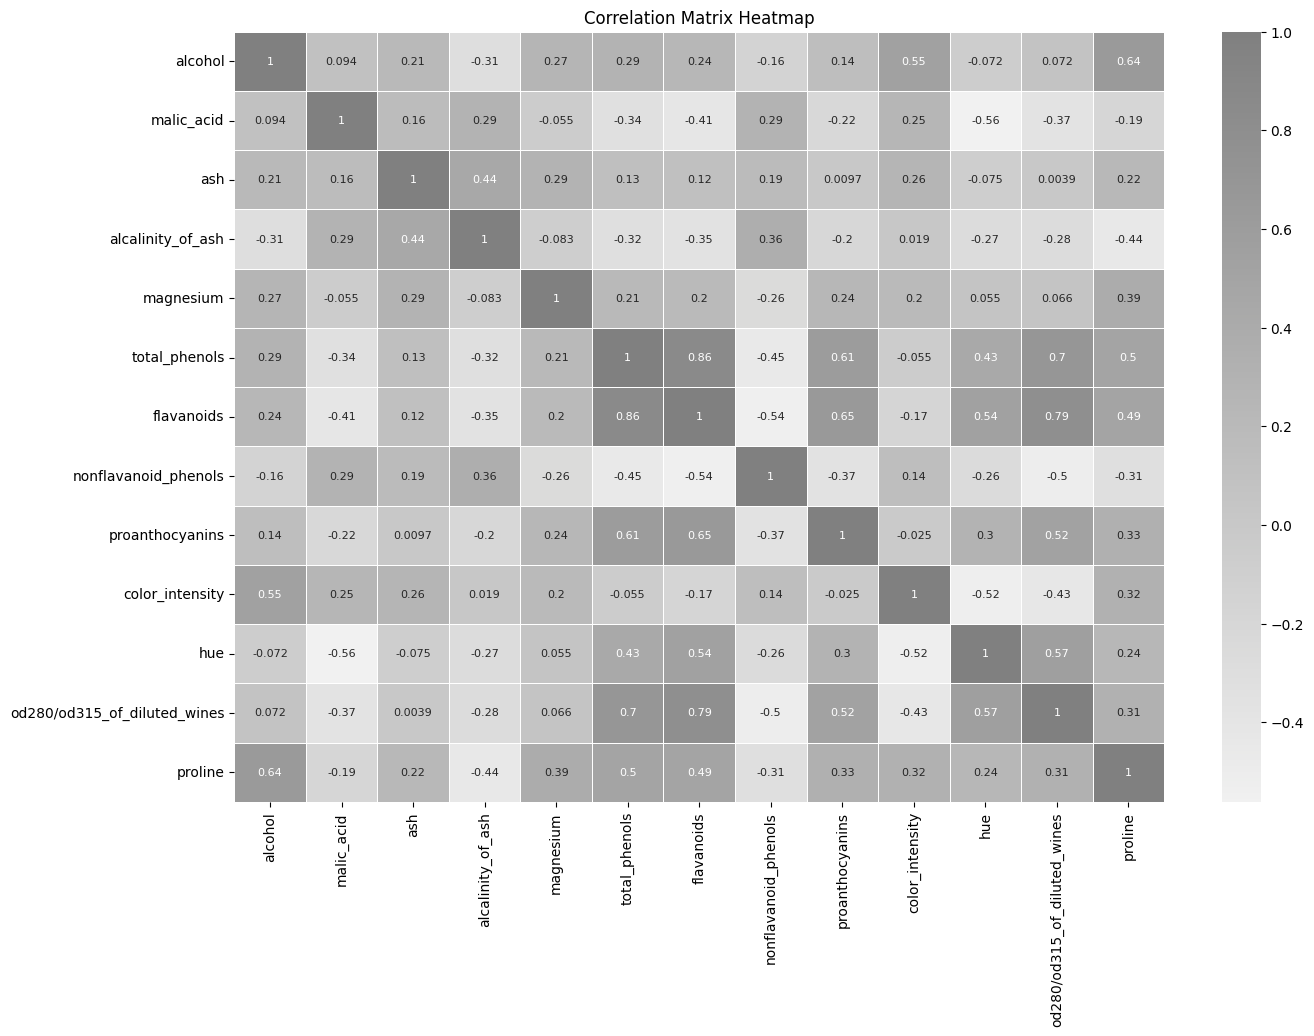

In [212]:
# Creating and plotting a correlation matrix with a heatmap
correlation_matrix = (pd.DataFrame(wine_data_cleaned, columns = wine_data.columns[:-1])).corr()
plt.figure(figsize = (15, 10))
sns.heatmap(correlation_matrix, annot = True, annot_kws={"size": 8}, cmap = sns.light_palette('gray', as_cmap=True), linewidths = 0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

Because PCA attempts to identify combinations that are able to explain variance in the original data, it requires the input features to be correlated to some extent, allowing the dimensionality to be effectively reduced. As shown in the correlation matrix, the features in the Wine dataset are fairly correlated with one another, which makes them suitable for PCA.

### PCA Implementation
*Dimensionality reduction using PCA*

This section implements PCA on the cleaned wine data to produce a set of principal components that adequately explain variance in the data while facilitating visualization and further analysis. It carries out the model fit, transformation, and scoring across several metrics.

The PCA algorithm automatically normalizes the feature data using z-scores, making it unnecessary to perform this step prior to using the model. Normalization reduces the possibility that the relative scale of the feature will impact model results, and is standard practice in supervised learning. Feature normalization rescales each feature to prevent skewing results based on feature magnitude, ensuring that no one feature will overly contribute to model predictions.

We begin by fitting PCA with a different number of specified components, which allows us to visualize how the explained variance changes as component count increases. We do so by creating an instance of the `PCA` class from the unsupervised learning package, and fitting it on the data for various numbers of components.

In [213]:
# Creating lists for variance and number of components
variance = []
n_components = []

# Fitting PCA and calculating explained variance for each number of components
for i in range(1, 14):
    pca = PCA(i)
    pca.fit(wine_data_cleaned)
    summed_variance = pca.variance.sum()
    variance.append(summed_variance)
    n_components.append(pca.n_components)

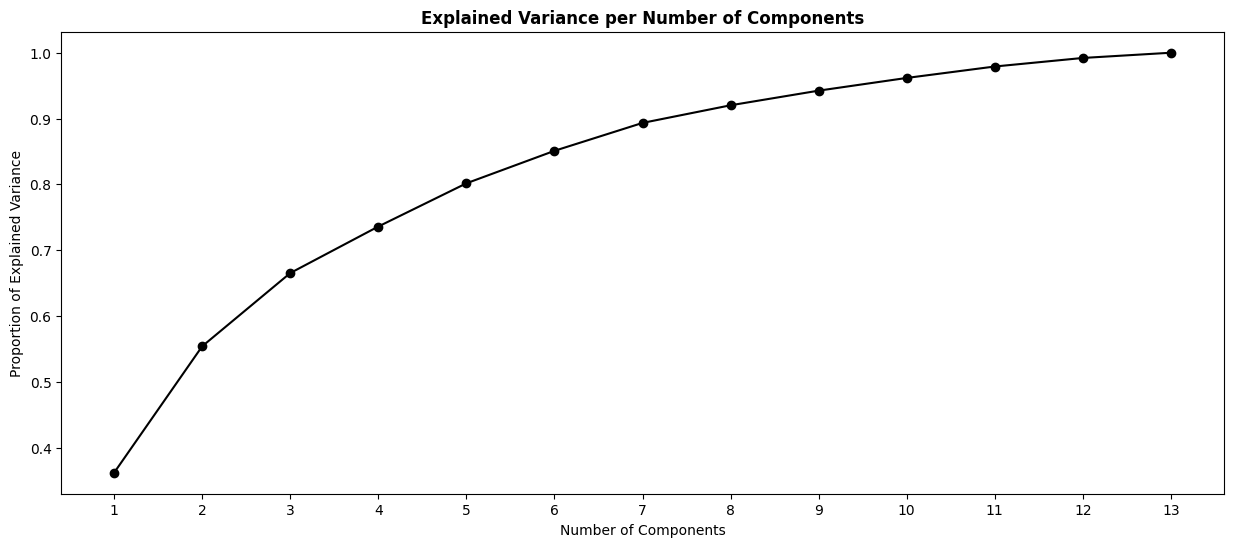

In [214]:
# Plotting the explained variance per number of components
plt.figure(figsize = (15, 6))
plt.plot(n_components, variance, 'black')
plt.scatter(n_components, variance, color = 'black')
plt.title('Explained Variance per Number of Components', fontweight = 'bold')
plt.xlabel('Number of Components')
plt.ylabel('Proportion of Explained Variance')
plt.xticks(range(1, 14))
plt.show()

As expected, the explained variance increases as the allowed number of components increases, eventually explaining all variance when each feature is treated as a separate principal component. This indicates that the PCA class is functioning as expected. The eigenvalues associated with each principal component can also be calculated and recorded, as given below.


In [215]:
# Using PCA with 13 components (maximum possible) and finding the eigenvalues
pca = PCA(13)
pca.fit(wine_data_cleaned)
eigenvalues = pca.eigenvalues

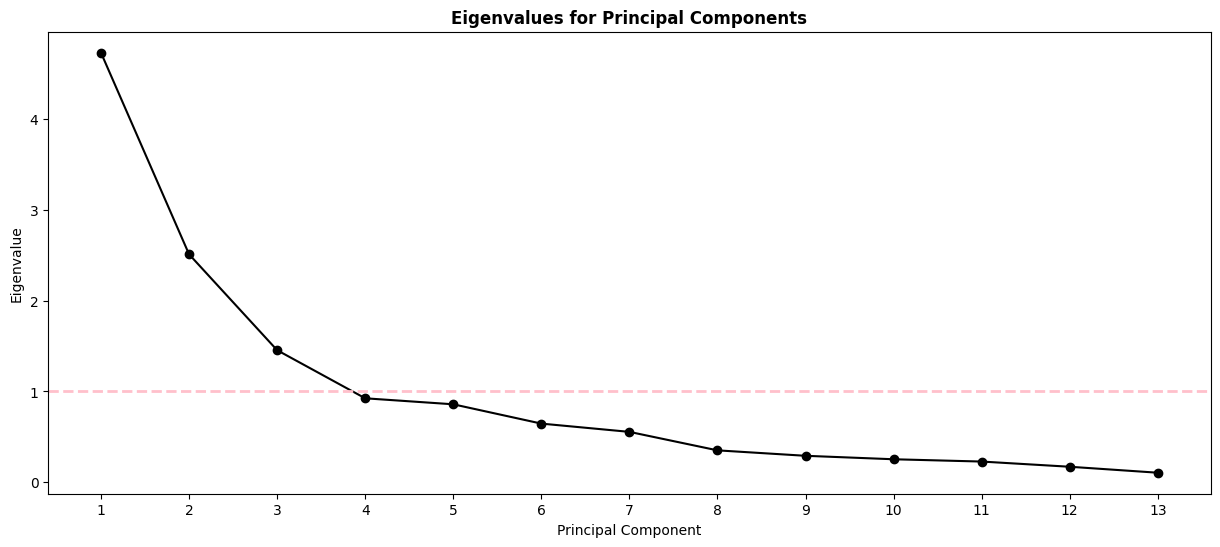

In [216]:
# Plotting the eigenvalues for each component
plt.figure(figsize = (15, 6))
plt.plot(n_components, eigenvalues, 'black')
plt.scatter(n_components, eigenvalues, color = 'black')
plt.title('Eigenvalues for Principal Components', fontweight = 'bold')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.xticks(range(1, 14))
plt.axhline(y = 1, color = 'pink', linestyle = '--', linewidth = 2)
plt.show()

A line has been drawn on the plot that indicates an eigenvalue of 1, a common cutoff point (Kaiser criterion) for determining the optimal number of principal components. In this data, three principal components have an eigenvalue greater than 1, so we will use these three for visualizatin purposes. Their combination explains approximately 60% - 70% of total variance.

We can now run PCA to return three principal components, and plot the transformed data in three-dimensional space.

This PCA has the following specifications:
- **Number of Components:** 3

In [217]:
# Fitting the model and transforming the data
pca = PCA(3)
pca.fit(wine_data_cleaned)
wine_data_pca = pca.transform(wine_data_cleaned)

# Printing the results
print(f"Returned PCA Values: \n\
{'-' * 20}\n\
Components: \n\
    {np.array2string(pca.components, precision = 3, separator=', ', suppress_small=True, prefix='    ')} \n\
Variance: \n \
    {np.array2string(pca.variance, precision = 3)}\n\
Eigenvalues:   \n \
    {np.array2string(pca.eigenvalues, precision = 3)}")

Returned PCA Values: 
--------------------
Components: 
    [[-0.144, -0.484, -0.207],
     [ 0.245, -0.225,  0.089],
     [ 0.002, -0.316,  0.626],
     [ 0.239,  0.011,  0.612],
     [-0.142, -0.3  ,  0.131],
     [-0.395, -0.065,  0.146],
     [-0.423,  0.003,  0.151],
     [ 0.299, -0.029,  0.17 ],
     [-0.313, -0.039,  0.149],
     [ 0.089, -0.53 , -0.137],
     [-0.297,  0.279,  0.085],
     [-0.376,  0.164,  0.166],
     [-0.287, -0.365, -0.127]] 
Variance: 
     [0.362 0.192 0.111]
Eigenvalues:   
     [4.732 2.511 1.454]


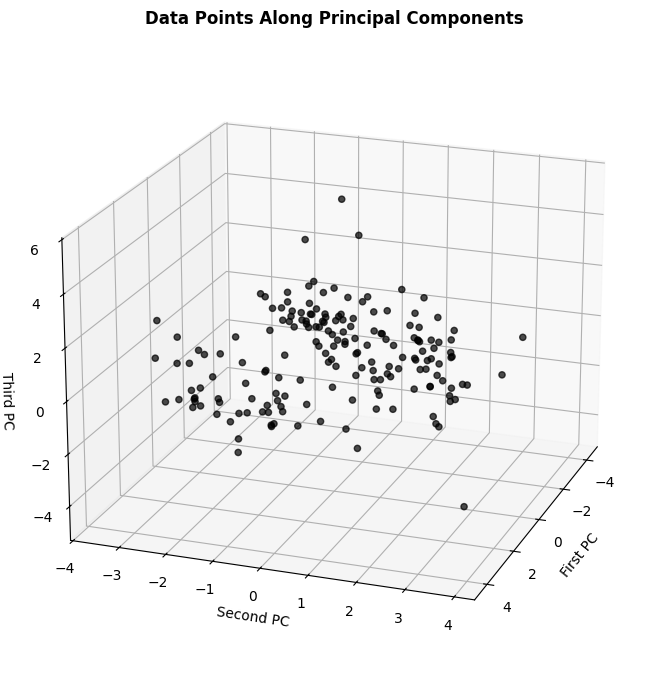

In [206]:
# Visualizing the transformed data
fig = plt.figure(figsize = (15, 7))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(wine_data_pca[:, 0], wine_data_pca[:, 1], wine_data_pca[:, 2], c = 'black', alpha = 0.7)
ax.set_xlabel("First PC")
ax.set_ylabel("Second PC")
ax.set_zlabel("Third PC")
ax.view_init(elev = 20, azim = 20)
plt.title("Data Points Along Principal Components", fontweight = "bold")
fig.tight_layout()
plt.show()

Three components have been identified with different feature loadings on each one. The first component explains around 36.2% of variance, the second 19.2%, and the third 11.1%. The transformed data is visualized above in three dimensions, and appears to have some clusters. Thus, the custom PCA has been validated as a means of dimensionality reduction, and may be applied prior to unsupervised clustering algorithms.

### Comparison with Existing Models
*Comparison with scikit-learn PCA*

In order to ensure that the custom-built PCA is functioning as intended and providing expected results, it is useful to compare its performance to PCA performed using established code. In this section, we rerun the analysis with all features using the scikit-learn PCA with a matching number of principal components and solving method to verify the results of the custom PCA.

In [218]:
# Creating a sklearn PCA model
from sklearn.decomposition import PCA
wine_data_normal = z_score_standardize(wine_data_cleaned)
pca_sk = PCA(3, svd_solver = 'full')
pca_sk.fit(wine_data_normal)
components_sk = pca_sk.components_.T

In [ ]:
# Printing the results
print(f"Returned PCA Values: \n\
{'-' * 20}\n\
Components: \n\
    {np.array2string(components_sk, precision = 3, separator=', ', suppress_small=True, prefix='    ')} \n\
Variance: \n \
    {np.array2string(pca_sk.explained_variance_ratio_, precision = 3)}\n\
Eigenvalues:   \n \
    {np.array2string(pca_sk.explained_variance_, precision = 3)}")

Returned PCA Values: 
--------------------
Components: 
    [[ 0.144,  0.484, -0.207],
     [-0.245,  0.225,  0.089],
     [-0.002,  0.316,  0.626],
     [-0.239, -0.011,  0.612],
     [ 0.142,  0.3  ,  0.131],
     [ 0.395,  0.065,  0.146],
     [ 0.423, -0.003,  0.151],
     [-0.299,  0.029,  0.17 ],
     [ 0.313,  0.039,  0.149],
     [-0.089,  0.53 , -0.137],
     [ 0.297, -0.279,  0.085],
     [ 0.376, -0.164,  0.166],
     [ 0.287,  0.365, -0.127]] 
Variance: 
     [0.362 0.192 0.111]
Eigenvalues:   
     [4.732 2.511 1.454]


The scikit-learn PCA results exactly match those of the custom class. Because PCA does not introduce an element of randomness, this is an expected result, indicating that the custom PCA has no errors in mathematical implementation. Therefore, the custom `rice_ml` PCA is able to handle multi-feature dimensionality reduction to a professional standard.